# Figure 6 Flood risk of motorways and trunk roads in the European main road network

In [1]:
import sys
sys.path.append("..") #import folder which is one level higher

import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import os as os
import postproc_functions as post
import pandas as pd
from tqdm import tqdm
from collections import OrderedDict

from utils_functions import load_config

### Load NUTS-shapefiles to be used as background layers

In [2]:
# Load the background NUTS-division shapefiles as background maps.
NUTS3 = gpd.read_file(os.path.join(load_config()['paths']['input_data'],load_config()['filenames']['NUTS3-shape']))
ori = NUTS3.copy()

NUTS0 = post.NUTS_0_list(EU28=True,EFTA=True,CAND=True) #draw the list of NUTS-0 regions
NUTS0 = [e for e in NUTS0 if e not in ['IS','MT','CY','TR']] #drop Iceland, Malta and Cyprus, Turkey for now
NUTS3_lst = []
for N0 in NUTS0:
    NUTS3_lst.extend(post.NUTS_up(N0,True)) #find all the correspondign NUTS-3 regions
regions = [e for e in NUTS3_lst if e not in post.NUTS_3_remote(Overseas=True,Creta=True,Spain=True)] #remove all the NUTS-3 regions we don't want to plot

NUTS3 = NUTS3[NUTS3['NUTS_ID'].isin(regions)]
NUTS3.head()

LEVL_CODE NUTS_ID CNTR_CODE                    NUTS_NAME    FID  \
0          3   HR043        HR  Krapinsko-zagorska županija  HR043   
1          3   AT314        AT              Steyr-Kirchdorf  AT314   
2          3   AT315        AT                 Traunviertel  AT315   
3          3   DE600        DE                      Hamburg  DE600   
4          3   DE711        DE  Darmstadt, Kreisfreie Stadt  DE711   

                                            geometry  
0  POLYGON ((4804562.000 2571297.000, 4803972.000...  
1  POLYGON ((4654777.000 2787028.000, 4653848.000...  
2  POLYGON ((4600507.000 2785382.000, 4600808.000...  
3  MULTIPOLYGON (((4317388.000 3393935.000, 43177...  
4  POLYGON ((4229546.000 2983212.000, 4230168.000...

In [3]:
background = gpd.read_file(os.path.join(load_config()['paths']['input_data'],load_config()['filenames']['NUTS0-shape'])) #country map (NUTS-0)

### Set the domain of the plot in EPSG:3035 coordinates

In [12]:
#Get x- and y-axis from the chosen domain

#Define x and y-axis for further use in the script
#x_axis = ax_base.get_xlim()
#y_axis = ax_base.get_ylim()

#... or set them manually:

x_axis = (2500000, 5900000)
y_axis = (1500000, 5400000)
print(x_axis,y_axis)

(2500000, 5900000) (1500000, 5400000)


### Load the not-yet-disrupted motorway network of Europe

In [4]:
# Load backgroundmap containing the (not-yet-disrupted) motorway network of Europe
background_maps = r"D:/Europe_trade_disruptions/EuropeFloodResults/Model08_VMs/main/total_network"

#LOAD AND FILTER THE BACKGROUND MAP DATA
df_mw = pd.DataFrame()
df_tr = pd.DataFrame()
exceptions_bg = OrderedDict()
for region in tqdm(regions):
    try:
        df = pd.read_pickle(os.path.join(background_maps,"{}.pkl".format(region)))
        df_mw = df_mw.append(df.loc[df['road_type']=='motorway'])
        df_tr = df_tr.append(df.loc[df['road_type']=='trunk']) 
        #results = results.append(pd.read_pickle(os.path.join(background_maps,"{}.pkl".format(region))))
    except Exception as e:
        exceptions_bg[region] = str(e)
print(exceptions_bg)

100%|██████████████████████████████████████████████████████████████████████████████| 1417/1417 [05:53<00:00,  4.01it/s]

OrderedDict()


### Load the model results

In [12]:
# Load folder containing all model results
result_path = os.path.join(load_config()['paths']['postproc_output'],'baseline')

#LOAD THE FLOOD DATA
flood_mw = pd.DataFrame()
flood_tr = pd.DataFrame()
exceptions_flood = OrderedDict()
for region in tqdm(regions):
    try:
        df = pd.read_pickle(os.path.join(result_path,"{}_EAD_segment_litmix.pkl".format(region)))
        flood_mw = flood_mw.append(df.loc[df['road_type']=='motorway'])
        flood_tr = flood_tr.append(df.loc[df['road_type']=='trunk'])
    except Exception as e:
        exceptions_flood[region] = str(e)

#print(exceptions_flood)

100%|██████████████████████████████████████████████████████████████████████████████| 1417/1417 [03:16<00:00,  7.23it/s]


In [15]:
#set the projections of the source data to be able to convert it to another projection when plotting
CRS84 = {'init':'epsg:4326'}
CRSEU = {'init':'epsg:3035'}
df_mw.crs = CRS84
df_tr.crs = CRS84
flood_mw.crs = CRS84
flood_tr.crs = CRS84

C:\Users\Ginkel\AppData\Local\Continuum\anaconda3\envs\Leerdam37\lib\site-packages\pyproj\crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


# Choose colour scheme

In [17]:
scheme_name = "colour_scheme_dark_2"

#Region colours
background_color = "#706F6F" 
nodata = "grey" #regions with no data

#Line colours
country_borders = '#404040' #lines indicating the borders of countries 25% grey
NUTS_3_lines = "grey" #border of NUTS-regions
road_noflood = '#CCC155' #Roads that are not inundated
colors = ['#69CBF5','#FF3BFF']
colorgrading = mpl.colors.LinearSegmentedColormap.from_list(name='blauw',colors=colors,N=4) #colormap used for coloring the inundated roads

#Line thickness
l_mw_no = 2 #motorway not flooded
l_tr_no = 1 #trunk not flooded
l_mw_fl = 3 #motorway flooded
l_tr_fl = 2 #trunk flooded

In [11]:
#OSM COLOUR SCHEME - default theme

#scheme_name = "colour_scheme_OSM"

#Region colours
#background_color = "#F1F2DC" #OSM background color
3nodata = "#b5b4b0" #regions with no data

#Line colours
#country_borders = "#b5b4b0" #lines indicating the borders of countries
#NUTS_3_lines = "white" #border of NUTS-regions
#road_noflood = '#E892A2' #Roads that are not inundated
#colorgrading = mpl.colors.LinearSegmentedColormap.from_list(name='blauw',colors=['#58AACC','#58AACC','#58AACC','#58AACC','#58AACC'],N=20) #colormap used for coloring the inundated roads
#colorgrading = mpl.colors.LinearSegmentedColormap.from_list(name='blauw',colors=['#58AACC','#E34094'],N=4) #colormap used for coloring the inundated roads
#colorgrading = mpl.colors.LinearSegmentedColormap.from_list(name='blauw',colors=['#58AACC','#b4dc3c','#EB741A'],N=3) #colormap used for coloring the inundated roads
#colorgrading = mpl.colors.LinearSegmentedColormap.from_list(name='blauw',colors=['#b4dc3c','#58AACC'],N=10) #colormap used for coloring the inundated roads

#Line thickness
#l_mw_no = 2 #motorway not flooded
#l_tr_no = 1 #trunk not flooded
#l_mw_fl = 3 #motorway flooded
#l_tr_fl = 2 #trunk flooded

C:\Users\Ginkel\AppData\Local\Continuum\anaconda3\envs\Leerdam37\lib\site-packages\pyproj\crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
C:\Users\Ginkel\AppData\Local\Continuum\anaconda3\envs\Leerdam37\lib\site-packages\pyproj\crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
C:\Users\Ginkel\AppData\Local\Continuum\anaconda3\envs\Leerdam37\lib\site-packages\pyproj\crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
C:\Users\Ginkel\AppData\Local\Continuum\anaconda3\envs\Leerdam37\lib\site-packages\geopandas\plotting.py:529: UserWarning: The GeoDataFrame you are attempting to plot is empty. N

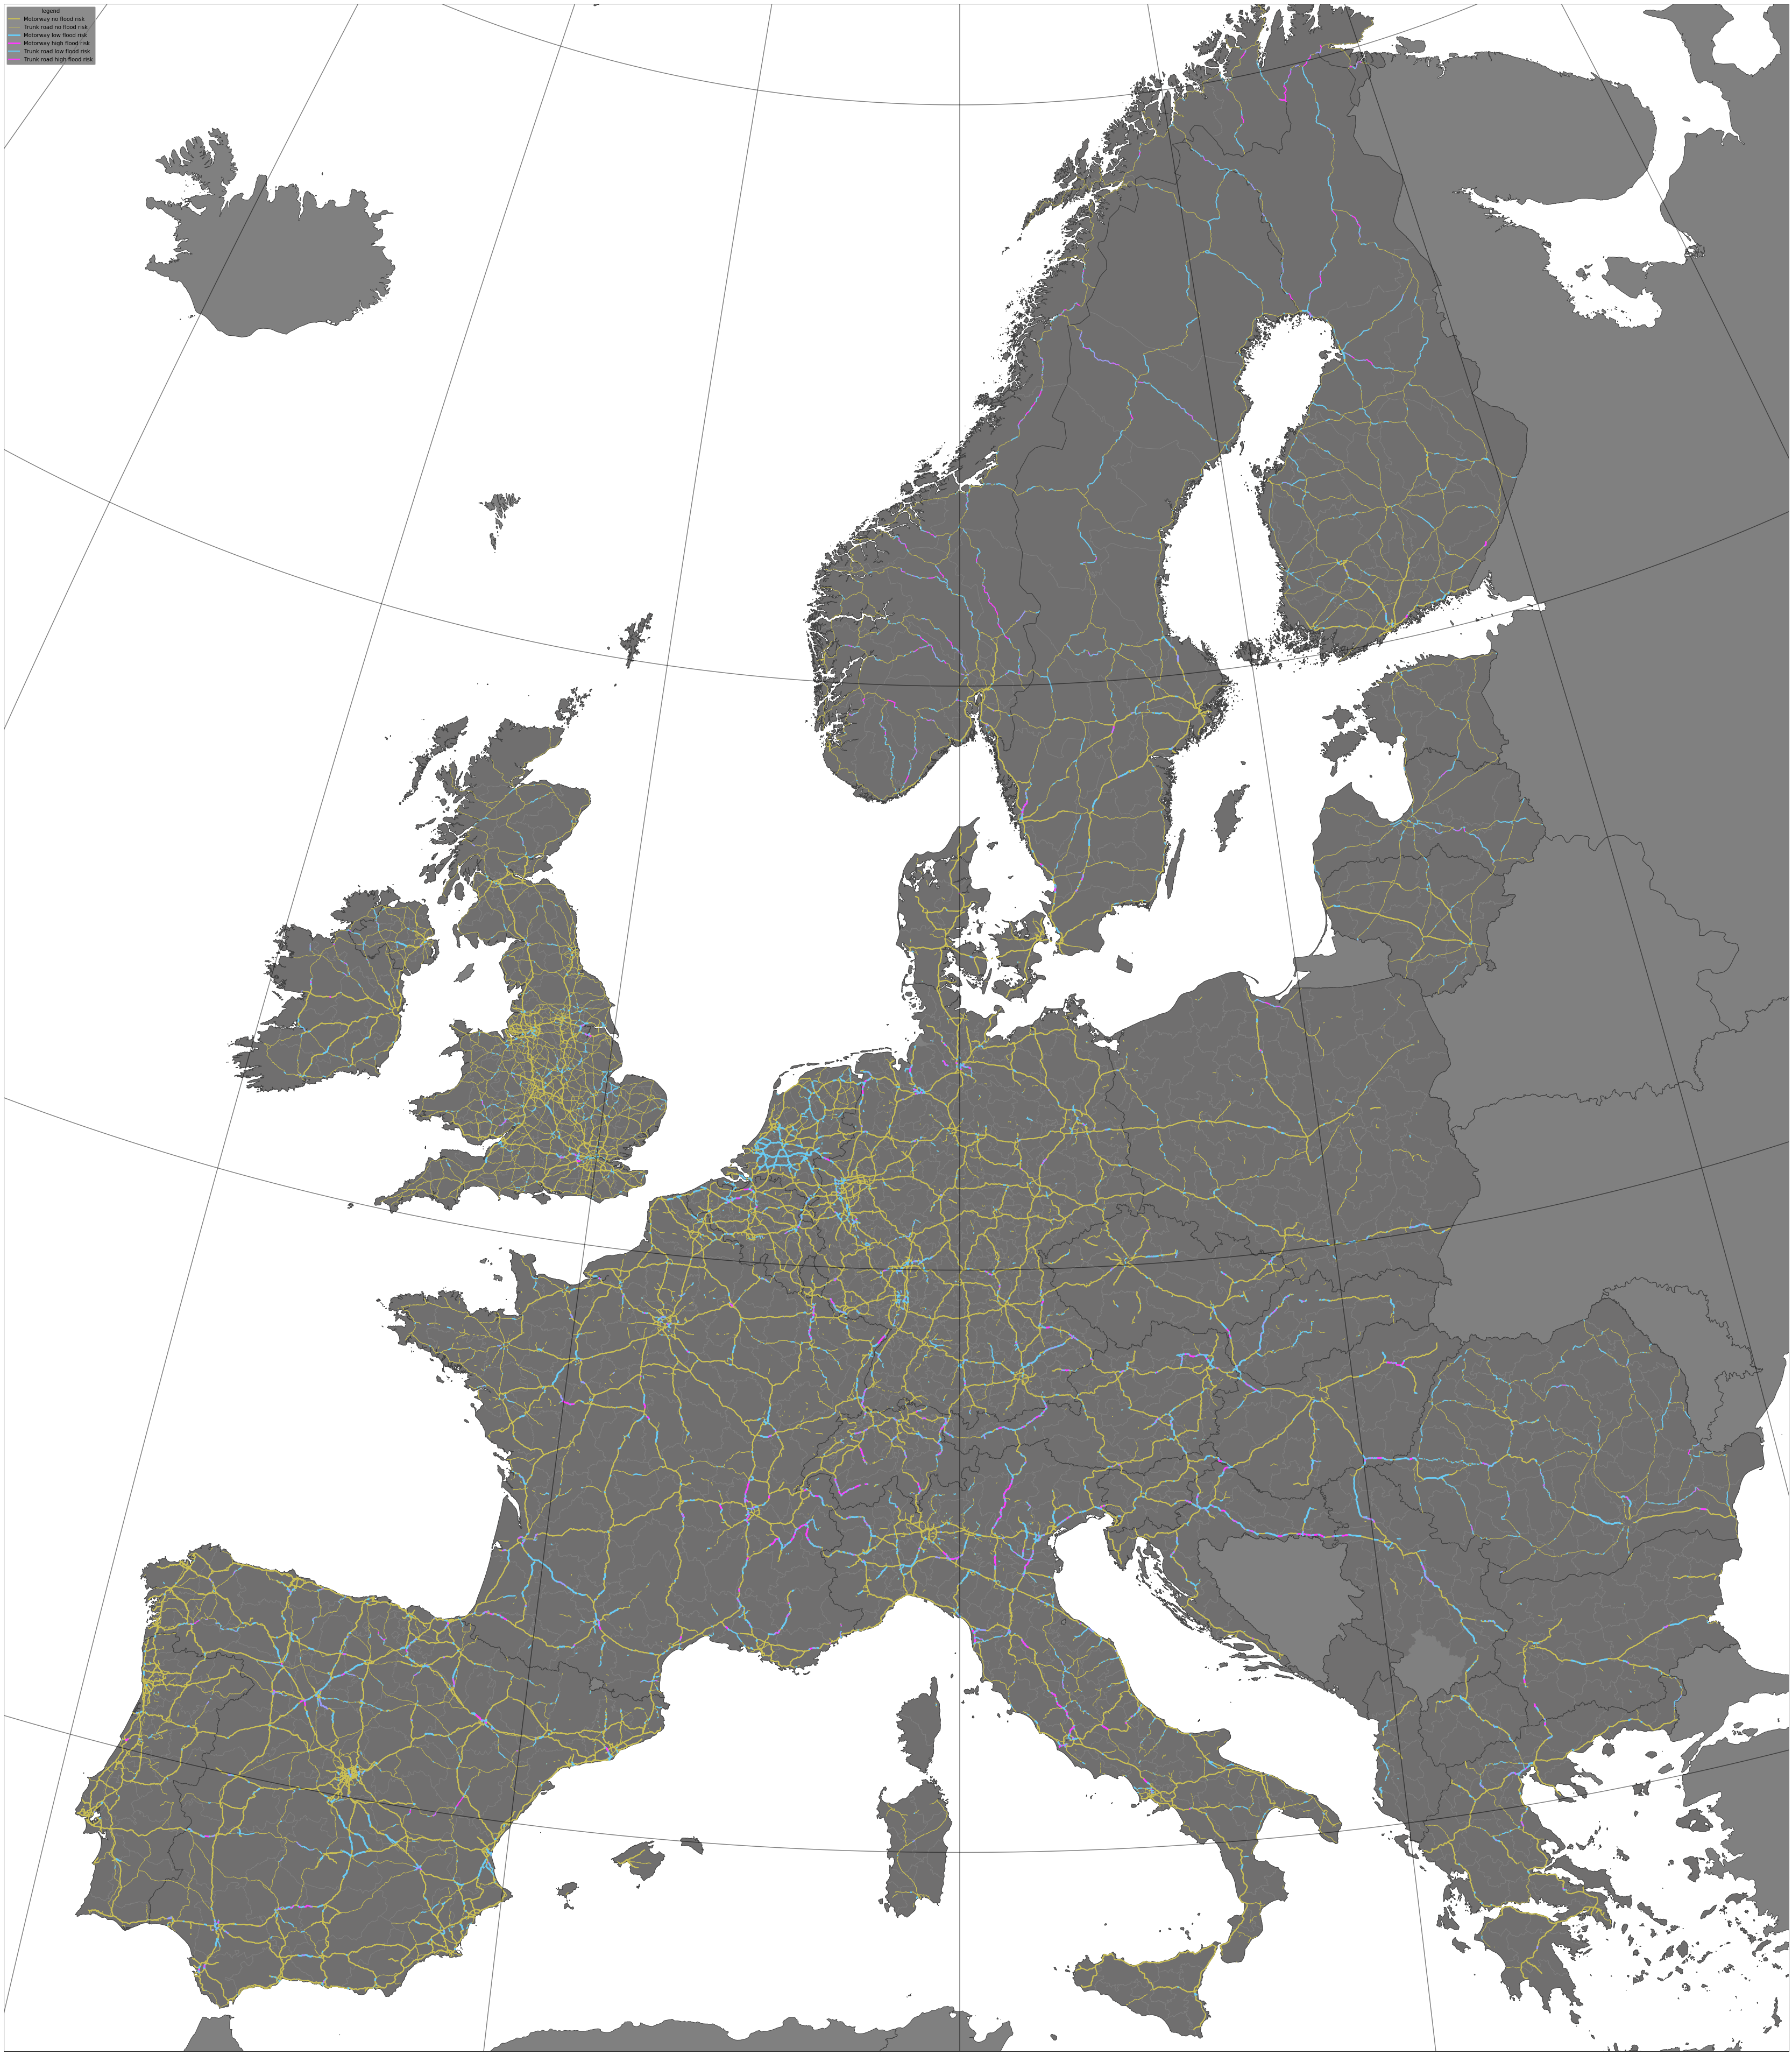

In [22]:
### MAKE THE PLOT
### FILTER AND PLOT ALL BACKGROUND DATA ###

fig, ax = plt.subplots(1, 1, figsize=(70,70))
#Background (country) map - used for areas without data
background.to_crs(CRSEU).plot(color=nodata,ax=ax) #Print the face color

#Background (NUTS-3) map
NUTS3.to_crs(CRSEU).plot(ax=ax, color=background_color, edgecolor=NUTS_3_lines) #lichtgrijs = #DFDFDF
#N0.loc[N0['FID']==super_region].to_crs({'init':'epsg:4326'}).plot(ax=ax, color='#DFDFDF')

# Plot the regions for which no background map data is available
no_background = ori[ori['NUTS_ID'].isin(list(exceptions_bg.keys()))]
no_background.to_crs(CRSEU).plot(ax=ax, color='grey')

# Plot the regions for which no background flood data is available
#no_flood = ori[ori['NUTS_ID'].isin(list(exceptions_flood.keys()))]
#no_flood.to_crs(CRSEU).plot(ax=ax, color='#DFDFDF')

#plot the country contour lines
background.to_crs(CRSEU).plot(facecolor='none',ax=ax,edgecolor=country_borders)

#Plot the background road map
df_tr.to_crs(CRSEU).plot(color=road_noflood, linewidth=l_tr_no,ax=ax)
df_mw.to_crs(CRSEU).plot(color=road_noflood, linewidth=l_mw_no,ax=ax)

ax.set_xlim(x_axis)
ax.set_ylim(y_axis)

#### PLOT FLOOD DATA ###
flood_tr.to_crs(CRSEU).plot(column='EAD_highflow',ax=ax, cmap=colorgrading, linewidth=l_tr_fl, legend=False, vmin=0, vmax=30000) 
flood_mw.to_crs(CRSEU).plot(column='EAD_highflow',ax=ax, cmap=colorgrading, linewidth=l_mw_fl, legend=False, vmin=0, vmax=30000) 

ax.tick_params(axis='both',which='both',bottom=False,top=False,left=False,right=False,labelbottom=False,labelleft=False)

#### #add gridlines

#New feature (14/4/2020): plot the gridlines of WGS84
#Ps, Ms = post.create_gridlines([20,25,30,35,40,45,50,55,60,65,70,75,80,85],
#                      [-30,-25,-20,-15,-10,-5,0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85],
#                      point_spacing = 10000)
Ps, Ms = post.create_gridlines([20,30,40,50,60,70,80],
                      [-30,-20,-10,0,10,20,30,40,50,60,70,80],
                      point_spacing = 10000)
Ps = Ps.to_crs("EPSG:3035")
Ms = Ms.to_crs("EPSG:3035")
lijndikte = 1.5
alfa = 0.5
Ps.plot(ax=ax,color='black',linewidth=lijndikte,alpha=alfa)
Ms.plot(ax=ax,color='black',linewidth=lijndikte,alpha=alfa)


### PREPARE LEGEND AND OTHER METADATA ###
legend_entries = []
legend_entries.append(plt.Line2D([0], [0], color=road_noflood, lw=l_mw_no, label='Motorway no flood risk'))
legend_entries.append(plt.Line2D([0], [0], color=road_noflood, lw=l_tr_no, label='Trunk road no flood risk'))
legend_entries.append(plt.Line2D([0], [0], color=colors[0], lw=l_mw_fl, label='Motorway low flood risk'))
legend_entries.append(plt.Line2D([0], [0], color=colors[1], lw=l_mw_fl, label='Motorway high flood risk'))
legend_entries.append(plt.Line2D([0], [0], color=colors[0], lw=l_tr_fl, label='Trunk road low flood risk'))
legend_entries.append(plt.Line2D([0], [0], color=colors[1], lw=l_tr_fl, label='Trunk road high flood risk'))

ax.legend(handles=legend_entries,loc='upper left',facecolor=background_color,title='legend')

In [23]:
fig.savefig("Paper_fig9_backgroundmap_{}_gridlines_fat.png".format(scheme_name), dpi=250, bbox_inches="tight")

# Save the results as a shapefile

In [25]:
flood_tr.memory_usage().sum()/(1024**(2))

23.247085571289062

In [35]:
df_tr.to_file("shapefile/trunk_roads.shp")

In [36]:
df_mw.to_file("shapefile/motorways.shp")

In [42]:
#remove 'rp' chars from column name, to make create unique names with < 10 chars
flood_tr_exp = flood_tr.copy()
flood_tr_exp.columns = [c.replace("rp","") for c in list(flood_tr.columns)]
flood_tr_exp.to_file("shapefile/flooded_trunk_roads.shp")

In [43]:
flood_mw_exp = flood_tr.copy()
flood_mw_exp.columns = [c.replace("rp","") for c in list(flood_mw.columns)]
flood_mw_exp.to_file("shapefile/flooded_motorways.shp")